In [1]:
## Load ICON 10KM

In [2]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import healpy

## test data

In [3]:
def get_nest(dx):
    return dx.crs.healpix_order == "nest"


def get_nside(dx):
    return dx.crs.healpix_nside


def attach_coords(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )

In [4]:
#####calculate the temporal mean
def calculate_temporal(data,function,latitude,longitude):
    dsel_temp = data.where(((data.lat>=latitude[0]) & (data.lat<=latitude[1])) & ((data.lon>=longitude[0]) & (data.lon<=longitude[1])),drop=True)
    if function == 'precip':
        dsel = dsel_temp
 # dsel = dsel_temp.resample(time='1H').mean()
    if function == 'cape':
        dsel = dsel_temp

    return dsel

In [5]:
### LOAD DATA
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
exp_id = "ngc4008"
experiment = cat.ICON[exp_id]

In [8]:
model_run = cat.ICON.ngc4008

In [12]:
import healpy

### select data
#ds = experiment(time="PT30M", zoom=7).to_dask().pipe(attach_coords)
ds = experiment(time="PT3H", zoom=9).to_dask().pipe(attach_coords)

In [13]:
ds['time']

<xarray.DataArray 'time' (time: 36520)>
array(['2020-01-01T03:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T09:00:00.000000000', ..., '2032-06-30T18:00:00.000000000',
       '2032-06-30T21:00:00.000000000', '2032-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T03:00:00 ... 2032-07-01
Attributes:
    axis:     T

In [15]:
#### select period
### summer
icon_jja = ds.pr.sel(time=ds.pr.time.dt.month.isin([6, 7, 8]))
icon_jja

<xarray.DataArray 'pr' (time: 5857, cell: 3145728)>
[18424528896 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 2020-06-01T00:30:00 ... 2021-07-01
    lat      (cell) float64 0.0746 0.1492 0.1492 ... -0.1492 -0.1492 -0.0746
    lon      (cell) float64 45.0 45.09 44.91 45.0 ... 315.0 315.1 314.9 315.0
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

In [16]:
###Select a region: domain - south of alps
region='south' # south, north, sw_greenland, 'sonnblick'

In [17]:
###Select a region: 
domains = {'usa_msc': {'lons':[262,272], 'lats':[31,41]},
           'usa_lojko': {'lons':[271,287], 'lats':[44,54]},
        'south': {'lons':[8,9.5], 'lats':[45.5,46.5]},
            'north': {'lons':[7., 8.5], 'lats':[47., 48.]},
            #'sw_greenland': {'lons':[-51.,-48.0], 'lats':[66., 68.]},
            'sw_greenland': {'lons':[309,312], 'lats':[66., 68.]},
            'sonnblick': {'lons':[12, 13.5], 'lats':[46.5, 47.5]}
          }
print(domains[region]['lats'],domains[region]['lons'])

[45.5, 46.5] [8, 9.5]


In [18]:
###Select a region: domain - south of alps
lons = domains[region]['lons']
lats =domains[region]['lats']
#south=calculate_temporal(data.tp,'precip',lats,lons)
#south

domain=calculate_temporal(icon_jja,'precip',lats,lons)

In [19]:
### Compute the mean over the region
box_mod = domain.mean(axis=1).resample(time='D').sum().compute()
box_mod

<xarray.DataArray 'pr' (time: 396)>
array([4.39788867e-03, 5.42958733e-03, 1.55972721e-05, 1.13205433e-05,
       4.32570378e-05, 3.79150780e-03, 5.08624502e-03, 4.52209171e-03,
       3.34694423e-03, 1.11188134e-03, 2.97628721e-04, 8.76154343e-04,
       7.80676492e-03, 5.88784181e-03, 4.38716915e-03, 5.64920576e-03,
       4.11095610e-03, 1.52792549e-02, 5.95883140e-03, 1.30564459e-02,
       4.19519842e-03, 7.73319975e-04, 7.47461221e-04, 5.34964819e-03,
       1.39305778e-02, 1.31143387e-02, 4.31049906e-04, 8.95188132e-05,
       1.04797271e-03, 1.62443630e-02, 6.05354551e-03, 1.77066668e-03,
       1.37489433e-05, 3.24308280e-06, 2.22001085e-03, 2.76444927e-02,
       1.79177709e-02, 7.19057862e-04, 4.00030785e-06, 2.29981256e-09,
       1.20549917e-03, 7.57413637e-03, 7.57784816e-04, 3.58312503e-02,
       2.13712774e-04, 6.28817454e-03, 5.77588473e-03, 1.99031504e-03,
       3.20917810e-04, 1.30677159e-04, 4.27774939e-05, 2.43839560e-04,
       2.87254916e-05, 2.18479568e-06, 1.20342411e-05, 2.59435736e-03,
       1.22330058e-02, 2.12439299e-02, 6.33883756e-04, 1.29365017e-05,
       1.39351289e-06, 1.45460523e-04, 5.63568574e-06, 1.01847763e-04,
       2.75478372e-03, 3.04574668e-02, 1.95872085e-03, 2.40085956e-05,
       5.91329008e-05, 9.22201201e-03, 1.92583844e-04, 2.60091219e-05,
       1.91683939e-05, 8.29633791e-06, 1.38617319e-03, 1.96444313e-03,
       2.11800030e-03, 4.44292324e-04, 5.88161580e-04, 2.53505842e-03,
...
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 2.87961506e-04, 7.58648291e-03, 5.37934201e-03,
       1.08111755e-03, 4.59342904e-04, 3.09231179e-03, 4.09908919e-03,
       1.29576505e-03, 1.69280637e-03, 2.75720423e-03, 4.62266896e-03,
       1.30374613e-03, 2.98174535e-04, 2.44984520e-04, 1.00423442e-03,
       3.66450893e-03, 3.19932564e-03, 1.43987840e-04, 4.99850698e-03,
       7.79005131e-06, 1.25447148e-03, 1.39330607e-02, 1.43438652e-02,
       2.25668307e-03, 1.75781752e-04, 4.18779440e-04, 3.17804841e-03,
       1.06773935e-02, 1.85649283e-02, 1.70907602e-04, 2.79428900e-06],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2021-07-01

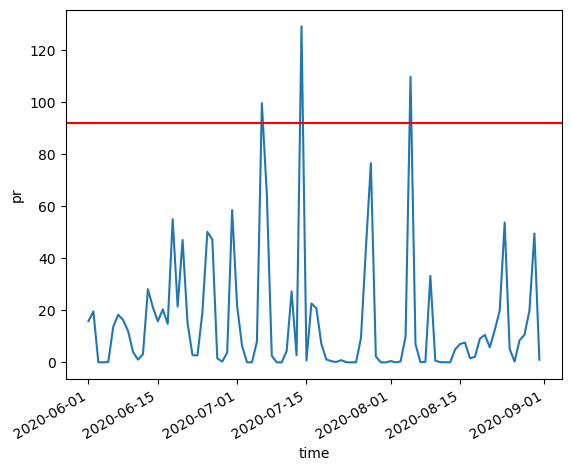

In [29]:
#(box_mod*60*60).plot()
(box_mod*60*60).sel(time=box_mod.time.dt.year.isin([2020])).plot()
plt.axhline(y=(0.0255654*60*60), color='r', linestyle='-')

In [21]:
### max value
box_mod_max = box_mod.chunk(dict(time=-1)).idxmax(dim="time").compute()
box_mod_max

<xarray.DataArray 'time' ()>
array('2020-07-14T00:00:00.000000000', dtype='datetime64[ns]')

In [22]:
box_mod_max.values

numpy.datetime64('2020-07-14T00:00:00.000000000')

## make a plot with nnshow

In [31]:
### plot from 
#August 8-16, 2024

In [32]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import healpy
from matplotlib import cm

In [95]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    kwargs: additional arguments to imshow
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)
def worldmap(var, **kwargs):
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    #projection = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(
        figsize=(12, 10), subplot_kw={"projection": projection}, constrained_layout=True
    )
    #ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
def get_nest(dx):
    return dx.crs.healpix_order == "nest"


def get_nside(dx):
    return dx.crs.healpix_nside


def attach_coords(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )


In [91]:
def hacky_linear_interpolation(data, target_grid, target_value, dim="level_full"):
    level_above = (target_grid > target_value).argmax(dim=dim)
    level_below = level_above - 1
    value_above = target_grid.isel(**{dim: level_above})
    value_below = target_grid.isel(**{dim: level_below})
    f = (target_value - value_below) / (value_above - value_below)
    return (1-f) * data.isel(**{dim: level_below}) + f * data.isel(**{dim: level_above})

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

In [37]:
print(domains[region]['lats'],domains[region]['lons'])
#ds

[45.5, 46.5] [8, 9.5]


In [46]:
# Find the HEALPix pixels that are closest to the 1x1 degree grid points.
#lon = np.arange(0, 40, 1)
#lat = np.arange(60, 30, -1)
#pix = xr.DataArray(
#    hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
#    coords=(("lat", lat), ("lon", lon)),
#)

In [113]:
data=model_run(zoom=2, time="P1D").to_dask().pr.sel(time="2020-07-10")
data

<xarray.DataArray 'pr' (cell: 192)>
[192 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2020-07-10
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

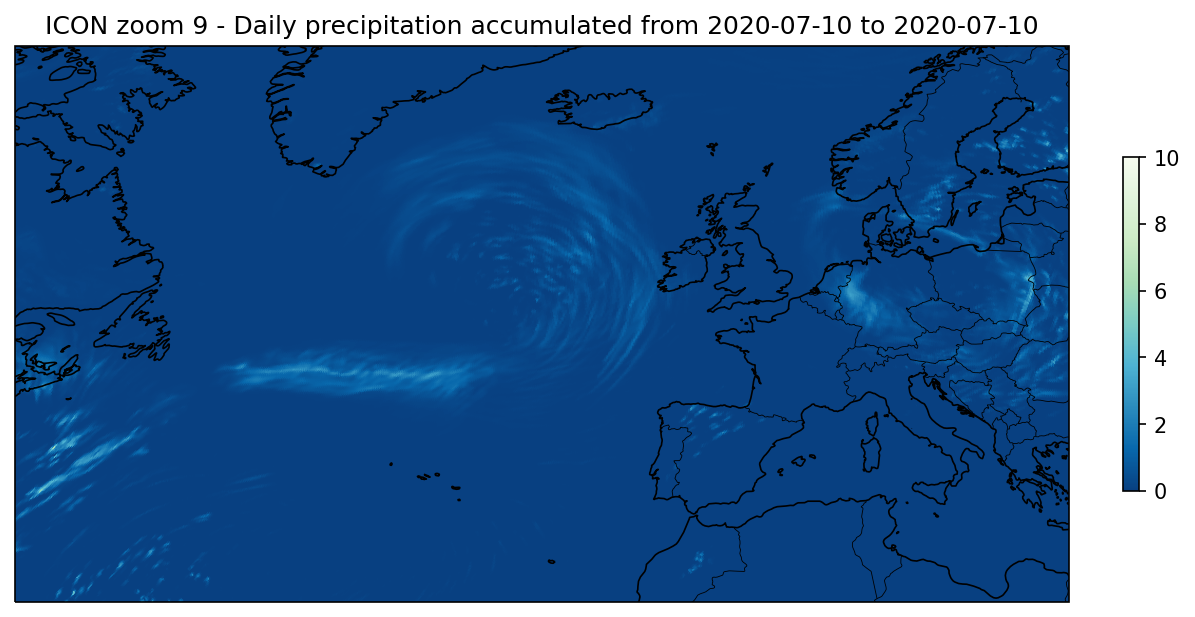

In [158]:
#Time of max intensity to the south of Swiss alps '2020-07-14T00:00:00.000000000'
#cmap = cm.RdYlBu_r
#cmap = cm.twilight
cmap = cm.GnBu_r
cmap.set_under('w')
datum0="2020-07-10"
datum="2020-07-10"
data = model_run(zoom=9, time="P1D").to_dask().pr.sel(time=slice(datum0, datum)).sum(dim="time")


#data = model_run(zoom=9,time="P1D").to_dask().rlut.sel(time='2020-07-14T00:00') 
#data = model_run(zoom=9,time="P1D").to_dask().pr.sel(time='2020-07-14T00:00') 
#data = model_run(zoom=9, time="P1D").to_dask().prw.sel(time='2020-07-14T00:00')

#data = model_run(zoom=9, time="P1D").to_dask().rlut.sel(time='2020-07-14T00:00') 
#data = model_run(zoom=9, time="PT3H").to_dask().pr.sel(time='2020-07-14T00:00')
#data = model_run(zoom=9, time="PT3H").to_dask().rlut.sel(time='2020-07-14T00:00')
#data = model_run(zoom=9, time="PT3H").to_dask().prw.sel(time='2020-07-14T00:00')

#data = model_run(zoom=9, time="PT30M").to_dask().pr.sel(time='2020-07-14T00:00')
#data = model_run(zoom=9, time="PT30M").to_dask().rlut.sel(time='2020-07-14T00:00')
#data = model_run(zoom=9, time="PT30M").to_dask().qgvi.sel(time='2020-07-14T00:00')
#data = model_run(zoom=9, time="PT30M").to_dask().cllvi.sel(time='2020-07-14T00:00')

projection = ccrs.Robinson(central_longitude=10)
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, dpi=150, constrained_layout=True
)

ax.set_title("ICON zoom 9 - Daily precipitation accumulated from "+datum0+" to "+datum)

            #  lon1,lon2,lat1,lat2
#ax.set_extent([5, 12, 45, 48], crs=ccrs.PlateCarree())
#ax.set_extent([-180, 180, 0, 88], crs=ccrs.PlateCarree())
ax.set_extent([-60, 25, 30, 70], crs=ccrs.PlateCarree())
#ax.set_extent([-10, 30, 30, 60], crs=ccrs.PlateCarree())


im=nnshow(data*60*60, ax=ax, cmap=cmap, vmin=0.0, vmax=10)
#im=nnshow(data*60*60, ax=ax, cmap=cmap)


ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

fig.colorbar(im,shrink=0.6)
#fig.colorbar()

plt.savefig("ICON-P1D-ZOOM09-_"+datum+".png")

## Downloading variables

In [3]:
###plot
###Functions
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    var: variable on healpix coordinates (array-like)
    nx: image resolution in x-direction
    ny: image resolution in y-direction
    ax: axis to plot on
    kwargs: additional arguments to imshow
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=True, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)


def worldmap(var, **kwargs):
    projection = ccrs.Robinson(central_longitude=-135.5808361)
    #projection = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(
        figsize=(12, 10), subplot_kw={"projection": projection}, constrained_layout=True
    )
    #ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

def get_nest(dx):
    return dx.crs.healpix_order == "nest"


def get_nside(dx):
    return dx.crs.healpix_nside


def attach_coords(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )

def hacky_linear_interpolation(data, target_grid, target_value, dim="level_full"):
    level_above = (target_grid > target_value).argmax(dim=dim)
    level_below = level_above - 1
    value_above = target_grid.isel(**{dim: level_above})
    value_below = target_grid.isel(**{dim: level_below})
    f = (target_value - value_below) / (value_above - value_below)
    return (1-f) * data.isel(**{dim: level_below}) + f * data.isel(**{dim: level_above})

import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import healpy
from matplotlib import cm
import sys
import os

In [5]:
### pressure levels (prl) or surface (sfc) 
levs="prl"

### Pressure level to interpolate
prs=50000

### variable
var='zg'

version="ngc4008"

dir_res="/scratch/b/b382006/nextgems/prefinal/"+version+"/"+var+"/daily/"
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

print("Saving in :", dir_res)

###Load catalog
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
#model_run = cat.ICON.ngc3028


### Load data, we add chunks="auto"
#ds_fine = cat["ICON"][version](zoom=7, time="PT3H",chunks="auto").to_dask()
#ds_fine = cat.ICON[version](zoom=7,time="PT3H",chunks={}).to_dask()
ds_fine = cat.ICON[version](zoom=7,time="P1D",chunks={}).to_dask()

Saving in : /scratch/b/b382006/nextgems/prefinal/ngc4008/zg/daily/


/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [41]:
### Load data, we add chunks="auto"
#ds_c3 = cat["ICON"]["ngc3028"](zoom=7, time="PT3H",chunks="auto").to_dask()


In [42]:
#ds_c3

In [12]:
#ds_fine['zg']

In [8]:
#ds_fine['time'][1:730:2]
yy0=ds_fine["time.year"][0].values
##yy0=2040
yyn=ds_fine["time.year"][-1].values
##yyn=2040
print(yy0,yyn)

2020 2050


In [14]:
# Find the HEALPix pixels that are closest to the 1x1 degree grid points.
lon = np.arange(0, 360, 1)
lat = np.arange(90, -91, -1)
pix = xr.DataArray(
    hp.ang2pix(ds_fine.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
)


In [ ]:
#for yyyy in range(yy0,yyn+1):
for yyyy in range(yy0+1,yyn+1):
    print(yyyy)
    for mm in range(1,13):
        yyyymm=str(yyyy)+'-'+str(mm).zfill(2)
        print(yyyymm)
#        period=ds_fine['time'].sel(time=yyyymm)
        var_prl = hacky_linear_interpolation(ds_fine[var], ds_fine.pfull.sel(time=yyyymm).compute(), prs)        
#        var_prl = hacky_linear_interpolation(ds_fine[var].sel(time=yyyymm), ds_fine.pfull.sel(time=yyyymm).compute(), prs)
        
        sample = np.reshape(var_prl.isel(cell=pix).values,newshape=(len(var_prl.time),len(lat),len(lon)))

# create DataArray with proper name, dimensions, and coordinates
        da = xr.DataArray(
            data=sample,
            name=var,
            dims=["time","lat", "lon"],
            coords=dict(
                lon=lon,
                lat=lat,
                time=var_prl.time,
            ),
            attrs=dict(
            ds_fine[var].attrs,
            ),
        )

#        da_6h=da.resample(time="6H").mean(keep_attrs=True)

#        da_6h.to_netcdf(dir_res+var+str(prs)+'_icon_prefinal_day_'+start[0:10]+'.nc')
        da.to_netcdf(dir_res+var+str(prs)+'_icon_prefinal_day_'+yyyymm+'.nc')
        

2021
2021-01
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-11
2022-12
2023
2023-01
2023-02
2023-03
